# **CAP 5516 - Medical Image Computing (Spring 2025)**
Programming Assignment #1 (30 points)

**Due: 2/10/2025, 11:59 PM (EST)**
#### **Deep Learning-based Pneumonia Detection Using Chest X-Ray Images**

According to the World Health Organization (WHO), pneumonia kills about 2 million children under 5 years
old every year and is consistently estimated as the single leading cause of childhood mortality [1]. In this
assignment, you will apply deep learning techniques to detect pneumonia based on pediatric chest X-rays.

**1. Dataset**

Dataset to be used for this assignment: Chest X-Ray Images (Pneumonia)
Where to download the dataset: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
Brief description of the dataset: The dataset is organized into 3 folders (train, test, val) and contains subfolders
for each image category (Pneumonia/Normal), see Fig. 1. There are 5,863 X-Ray images (JPEG) and 2
categories (Pneumonia/Normal). Chest X-ray images (anterior-posterior) were selected from retrospective
cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center,
Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
Fig. 1 Overview of the dataset structure.


**2. Task**

The task is to apply an off-the-shelf CNN or Transformer architecture for Pneumonia classification using X-ray images (i.e., binary classification - Pneumonia/Normal). You can choose any network architecture you
want. Since you may have limited computing resources, please consider using small networks such as ResNet-18, MobileNet, MobileNet-v2, ViT-Tiny, etc.
The train/val/test splits are provided within the dataset. The “train” set is for model training, the “val” set is for
validating the model generalization ability (e.g., preventing model overfitting) and hyperparameters tuning (e.g., learning rate), and “test” set is for model testing.
Assume ResNet-18 is used as the network backbone, please complete the following two sub-tasks.

Task 1.1– Train the model (e.g., ResNet-18) from scratch (i.e., random initialization of the model parameters) using the training X-ray images.

Task 1.2– Leverage the pre-trained ResNet-18 (the same CNN used in Task 1.1) model on the ImageNet and fine tune the model on the target X-ray images (training set). By using the techniques learned from class (e.g., data augmentation, model regularization, etc.), the goal is to achieve the best testing accuracy you can for Task 1.1 and Task 1.2. More training tricks or good practices can be found in [2].


**3. What to report**

For both sub-tasks, you should report:
1) The implementation details (e.g., network architecture, learning rate, batch size, training epoch, etc.).

2) A graph showing the training and validation loss curves. Fig. 2 shows an example. Tensorboard provides an easy way to track and visualize metrics such as loss and accuracy, see [4-7] for more information.

3) The overall classification accuracy on the testing set. The accuracy for each class (i.e., Pneumonia/Normal).

4) Show several failure cases (i.e., misclassified images). (Optional): Use CAM [8] or Grad-CAM [9] to
provide “visual explanations” for several predictions made by the model. This is very helpful for analyzing
failure cases. Software to use - TorchCAM: class activation explorer: https://github.com/frgfm/torch-cam
Epoch Fig. 2. An example of loss curves [3] for model diagnosis.


**4. What to submit**
1) A report for this assignment. The quality of the report is important.
2) Clean code and clear instructions (e.g., a readme file) to reproduce your results. If you choose to host the code on GitHub, please provide the GitHub link.


**References**

[1] Rudan, Igor, et al. "Epidemiology and etiology of childhood pneumonia." Bulletin of the world health organization 86 (2008): 408-416B.

[2] He, Tong, et al. "Bag of tricks for image classification with convolutional neural networks." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2019.
[Code]
https://github.com/weiaicunzai/Bag_of_Tricks_for_Image_Classification_with_Convolutional_Neural_Networ
ks

[3] https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

[4] https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html

[5] https://pytorch.org/docs/stable/tensorboard.html

[6] https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

[7] https://www.tensorflow.org/tensorboard/scalars_and_keras

[8] Zhou, Bolei, et al. "Learning deep features for discriminative localization." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016. [Code] https://github.com/zhoubolei/CAM

[9] Selvaraju, Ramprasaath R., et al. "Grad-cam: Visual explanations from deep networks via gradient-based localization." Proceedings of the IEEE international conference on computer vision. 2017. [Code]https://github.com/ramprs/grad-cam/

[10] Example of how to implement Pneumonia Detection: https://www.kaggle.com/code/teyang/pneumonia-detection-resnets-pytorch

[11] Load Checkpoint and Continue Training: https://medium.com/analytics-vidhya/saving-and-loading-your-model-to-resume-training-in-pytorch-cb687352fa61


## 1. Import Packages


In [2]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install opencv-python
%pip install mlxtend

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import os

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Load Dataset

In [3]:
# Load Directory and get classes
data_dir = 'dataset'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train', 'val', '__MACOSX']
['NORMAL', 'PNEUMONIA']


In [4]:
# Get the number of pneumonia training samples

pneumonia_files = os.listdir(data_dir + "/train/PNEUMONIA")
print('No. of training examples for Pneumonia:', len(pneumonia_files))
print(pneumonia_files[:5])

No. of training examples for Pneumonia: 3875
['person1000_bacteria_2931.jpeg', 'person1000_virus_1681.jpeg', 'person1001_bacteria_2932.jpeg', 'person1002_bacteria_2933.jpeg', 'person1003_bacteria_2934.jpeg']


In [5]:
# Get number of normal samples
 
normal_files = os.listdir(data_dir + "/train/NORMAL")
print('No. of training examples for Normal:', len(normal_files))
print(normal_files[:5])

No. of training examples for Normal: 1341
['IM-0115-0001.jpeg', 'IM-0117-0001.jpeg', 'IM-0119-0001.jpeg', 'IM-0122-0001.jpeg', 'IM-0125-0001.jpeg']


In [6]:
# Augment the dataset to increase number of samples for better training

dataset = ImageFolder(data_dir+'/train', 
                      transform=tt.Compose([tt.Resize(255),
                                            tt.CenterCrop(224),
                                            tt.RandomHorizontalFlip(),
                                            tt.RandomRotation(10),
                                            tt.RandomGrayscale(),
                                            tt.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            tt.ToTensor()
                                            #tt.Normalize(mean=[0.485, 0.456, 0.406], 
                                            #std=[0.229, 0.224, 0.225] ,inplace=True)
                                           ]))

dataset


Dataset ImageFolder
    Number of datapoints: 5216
    Root location: dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomGrayscale(p=0.1)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.05, 0.05))
               ToTensor()
           )

In [7]:
# Example of Image in Tensor Form
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 224, 224]) 0


tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.7176, 0.6902, 0.6706,  ..., 0.0000, 0.0000, 0.0000],
         [0.7216, 0.6980, 0.6824,  ..., 0.0000, 0.0000, 0.0000],
         [0.7176, 0.7137, 0.6863,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.7176, 0.6902, 0.6706,  ..., 0.0000, 0.0000, 0.0000],
         [0.7216, 0.6980, 0.6824,  ..., 0.0000, 0.0000, 0.0000],
         [0.7176, 0.7137, 0.6863,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

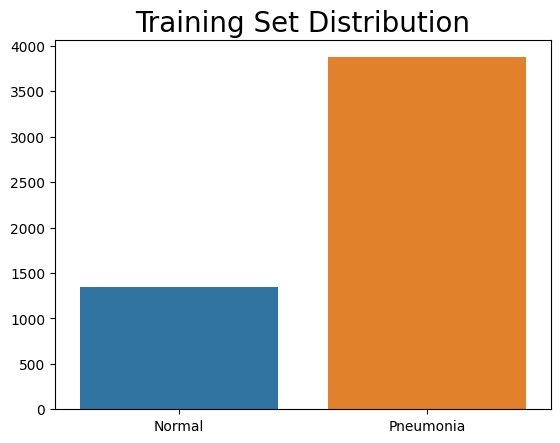

In [8]:
# Visualization of the dataset

# number of images for each class

train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/train/NORMAL', filename) 
                     for filename in os.listdir(data_dir+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(data_dir+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/train/PNEUMONIA')])]})


sns.barplot(data=train_samplesize).set_title('Training Set Distribution', fontsize=20)
plt.show()

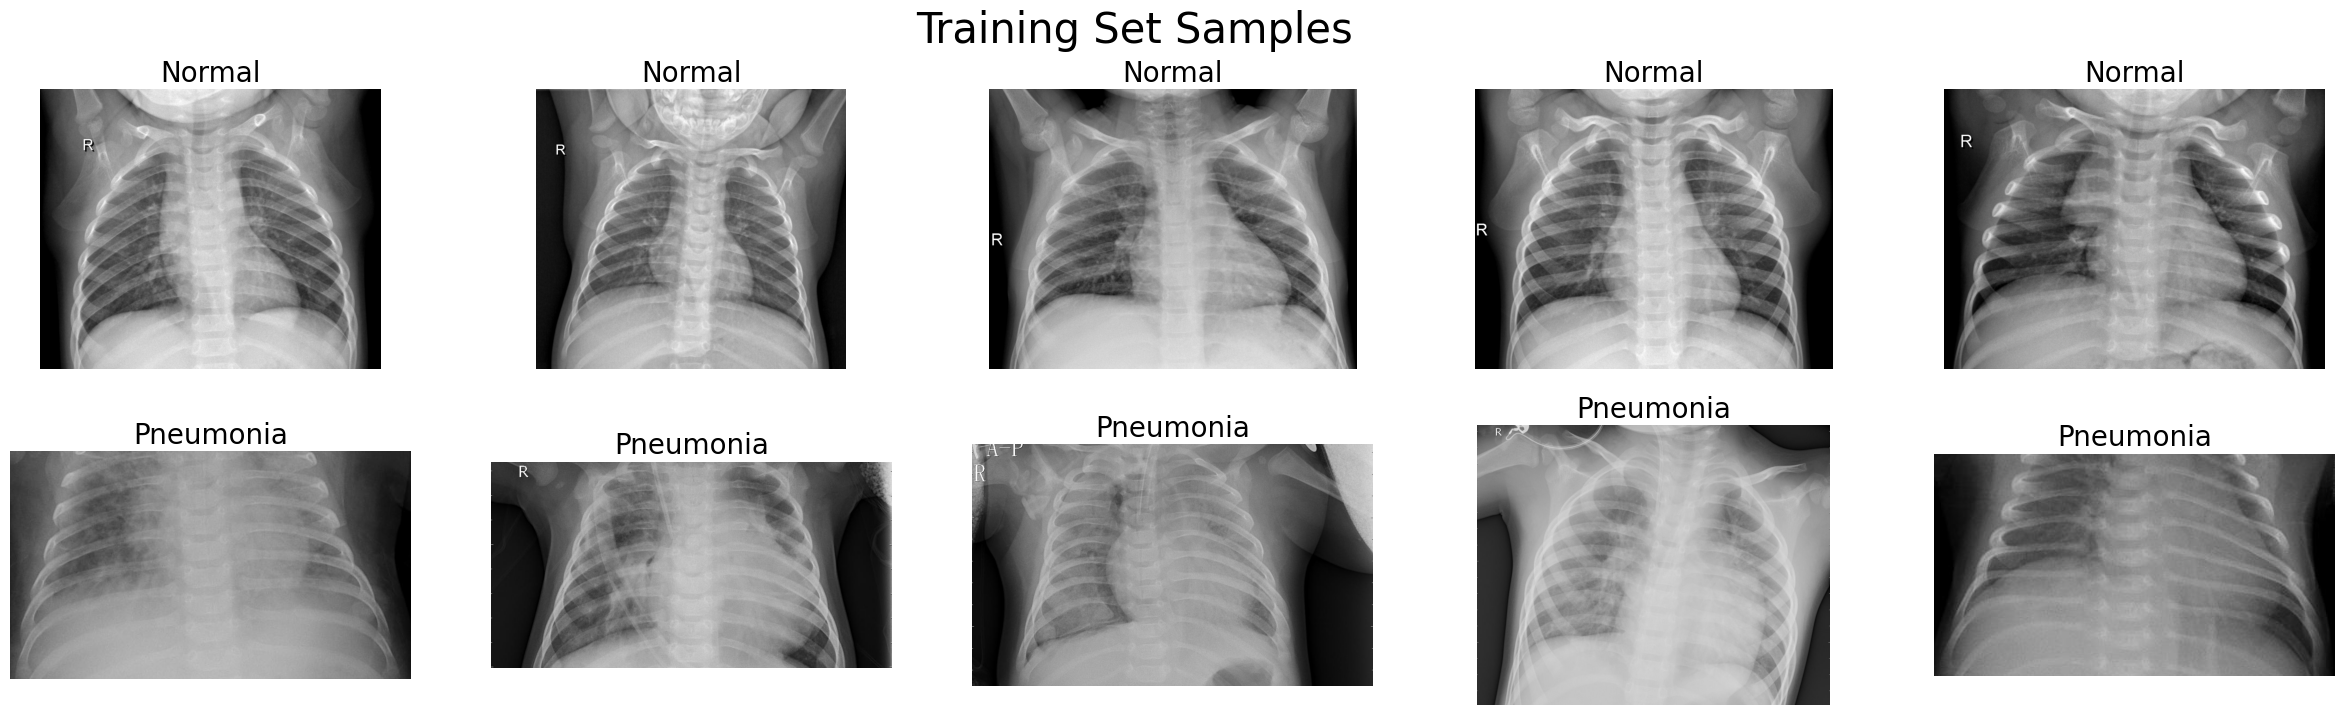

In [9]:
# View some of the images from the dataset

# Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,8))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("Normal", fontsize=20)
        else:
            ax[i//5][i%5].set_title("Pneumonia", fontsize=20)
        ax[i//5][i%5].axis('off')


## Plot training samples
rand_samples = random.sample([os.path.join(data_dir+'/train/NORMAL', filename) 
                              for filename in os.listdir(data_dir+'/train/NORMAL')], 5) + \
    random.sample([os.path.join(data_dir+'/train/PNEUMONIA', filename) 
                   for filename in os.listdir(data_dir+'/train/PNEUMONIA')], 5)

plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

# Process Dataset

**Split Training Set into Train, Validation and Test Data**

1. Training set - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.

2. Validation set - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.

3. Test set - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

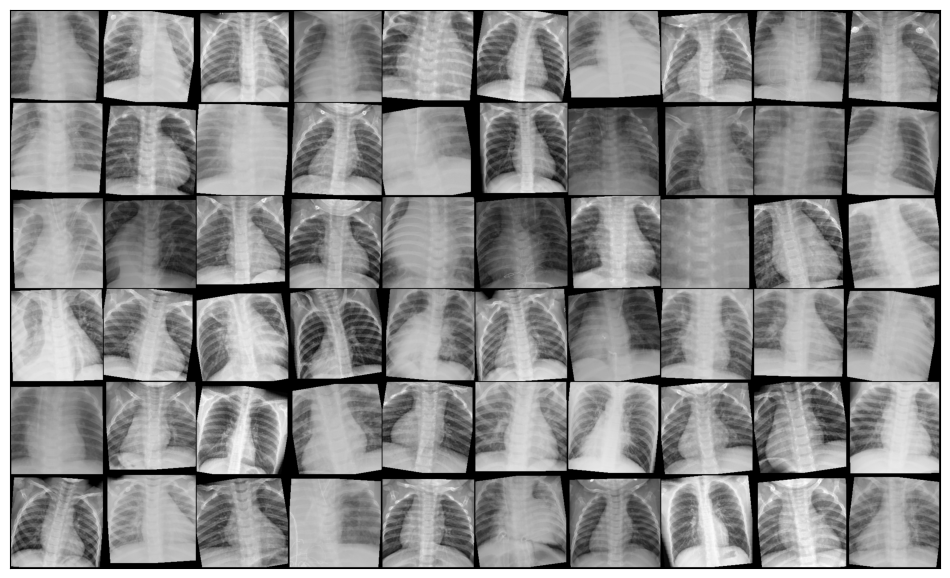

In [10]:
# set random seed so we get the same sampling every time for reproducibility

random_seed = 2020
torch.manual_seed(random_seed)

# Set training and validation set sizes
train_size = round(len(dataset)*0.7) # 70%
val_size = len(dataset) - train_size # 30%

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

# Set Batch Size
batch_size=128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)


# Visualize Batch of Data
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        break
        
show_batch(train_dl)

# Create Model

Train the ResNet Model from Scratch

In [11]:
# Set GPU Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to move data to device 
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


# Create Device Data Loader
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device) # yield will stop here, perform other steps, and the resumes to the next loop/batch

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

def F1_score(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    
    # precision, recall, and F1
    cm  = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))
    
    return precision,recall,f1,preds


class PneumoniaModelBase(nn.Module):
    
    # this is for loading the batch of train image and outputting its loss, accuracy 
    # & predictions
    def training_step(self, batch, weight):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels, weight=weight)      # weighted compute loss
        acc,preds = accuracy(out, labels)                       # calculate accuracy
        
        return {'train_loss': loss, 'train_acc':acc}
       
    # this is for computing the train average loss and acc for each epoch
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]       # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['train_acc'] for x in outputs]          # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
    
    # this is for loading the batch of val/test image and outputting its loss, accuracy, 
    # predictions & labels
    def validation_step(self, batch):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels)                     # compute loss
        acc,preds = accuracy(out, labels)                       # calculate acc & get preds
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}
    # detach extracts only the needed number, or other numbers will crowd memory
    
    # this is for computing the validation average loss and acc for each epoch
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]         # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]            # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    # this is for printing out the results after each epoch
    def epoch_end(self, epoch, train_result, val_result):
        print('Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.
              format(epoch+1, train_result['train_loss'], train_result['train_acc'],
                     val_result['val_loss'], val_result['val_acc']))
    
    # this is for using on the test set, it outputs the average loss and acc, 
    # and outputs the predictions
    def test_prediction(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}   

## Define Helper Functions to Fit and Evaluate Model

In [1]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, lr, model, train_loader, val_loader, weight, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache() # release all the GPU memory cache
    history = {}
    
#    Set up cutom optimizer with weight decay
#    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

#     Set up one-cycle learning rate scheduler
#     sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
#                                                 steps_per_epoch=len(train_loader))
#   sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    optimizer = opt_func(model.parameters(), lr)

    best_loss = 1 # initialize best loss, which will be replaced with lower better loss
    for epoch in range(epochs):
        
        # Training Phase 
        model.train() 
        train_outputs = []      
        lrs = []
        
        for batch in train_loader:
            outputs = model.training_step(batch, weight)
            loss = outputs['train_loss']                          # get the loss
            train_outputs.append(outputs)
            # get the train average loss and acc for each epoch
            train_results = model.train_epoch_end(train_outputs)                        
            loss.backward()                                       # compute gradients
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()                                      # update weights
            optimizer.zero_grad()                                 # reset gradients  
            
#             Record & update learning rate
#             lrs.append(get_lr(optimizer))
#             sched.step()
        
        # Validation phase
        val_results = evaluate(model, val_loader)
        
        # Save best loss
        if val_results['val_loss'] < best_loss and epoch + 1 > 15:
            best_loss = min(best_loss, val_results['val_loss'])
            best_model_wts = copy.deepcopy(model.state_dict())
            #torch.save(model.state_dict(), 'best_model.pt')
        
        # print results
        model.epoch_end(epoch, train_results, val_results)
        
        # save results to dictionary
        to_add = {'train_loss': train_results['train_loss'],
                  'train_acc': train_results['train_acc'],
                 'val_loss': val_results['val_loss'],
                  'val_acc': val_results['val_acc'], 'lrs':lrs}
        
        # update performance dictionary
        for key,val in to_add.items():
            if key in history:
                history[key].append(val)
            else:
                history[key] = [val]
    
    model.load_state_dict(best_model_wts)                         # load best model
    
    return history, optimizer, best_loss

NameError: name 'torch' is not defined

# Set up ResNet-18 Model

In [14]:


class PneumoniaResnetFromScratch(PneumoniaModelBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=False)
        # Freeze training for all layers before classifier
        for param in self.network.fc.parameters():
            param.require_grad = True  
        num_features = self.network.fc.in_features # get number of in features of last layer
        self.network.fc = nn.Linear(num_features, 2) # replace model classifier
    
    def forward(self, xb):
        return self.network(xb)
    

# Train Model and Evaluate



In [15]:
# Load Data and Model to GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

model_scratch = to_device(PneumoniaResnetFromScratch(), device)

/home/malneyugnfl/anaconda3/envs/deeplearning/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/malneyugnfl/anaconda3/envs/deeplearning/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [16]:
# Get VRAM Usage
!nvidia-smi

Mon Feb 10 20:17:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   41C    P0             33W /  125W |     316MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
# Set Parameters for Training

epochs = 40
lr = 0.0001
grad_clip = None
weight_decay = 1e-4
opt_func = torch.optim.Adam
# weighted loss for data class imbalance
weight = torch.FloatTensor([3876/(1342+3876), 1342/(1342+3876)]).to(device)

In [18]:
# Train

history_from_scratch, optimizer_from_scratch, best_loss_from_scratch = fit(epochs, lr, model_scratch, train_dl, val_dl, weight, 
                                    grad_clip=grad_clip, 
                                    weight_decay=weight_decay, 
                                    opt_func=opt_func)

print("Optimal Loss: ", best_loss_from_scratch)

Epoch [1], train_loss: 0.2684, train_acc: 0.8899, val_loss: 1.5694, val_acc: 0.7247
Epoch [2], train_loss: 0.1642, train_acc: 0.9344, val_loss: 0.3094, val_acc: 0.8850
Epoch [3], train_loss: 0.1375, train_acc: 0.9507, val_loss: 0.4425, val_acc: 0.8707
Epoch [4], train_loss: 0.1188, train_acc: 0.9545, val_loss: 0.4173, val_acc: 0.8497
Epoch [5], train_loss: 0.1031, train_acc: 0.9618, val_loss: 0.1469, val_acc: 0.9357
Epoch [6], train_loss: 0.0975, train_acc: 0.9644, val_loss: 0.1517, val_acc: 0.9423
Epoch [7], train_loss: 0.0853, train_acc: 0.9659, val_loss: 0.1877, val_acc: 0.9319
Epoch [8], train_loss: 0.0881, train_acc: 0.9690, val_loss: 0.2751, val_acc: 0.9031
Epoch [9], train_loss: 0.0740, train_acc: 0.9705, val_loss: 0.1360, val_acc: 0.9467
Epoch [10], train_loss: 0.0724, train_acc: 0.9728, val_loss: 0.2306, val_acc: 0.9359
Epoch [11], train_loss: 0.0709, train_acc: 0.9715, val_loss: 0.1710, val_acc: 0.9340
Epoch [12], train_loss: 0.0757, train_acc: 0.9717, val_loss: 0.3690, val_a

# Save Model

In [19]:
# Save Model
bestmodel = {'model': PneumoniaResnetFromScratch(),
              'state_dict': model_scratch.state_dict(),
              'optimizer' : optimizer_from_scratch.state_dict()}

torch.save(bestmodel, 'PneumoniaResnet_From_Scratch.pth')

# Load Saved Model and Continue Training Again

In [20]:
# this is for loading the model from a previously saved one

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

# model = load_checkpoint('./PneumoniaResnet.pth')

# Create ResNet-18 Model with Pretrained Weights



In [21]:
class PneumoniaResnet_Pretrained(PneumoniaModelBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Freeze training for all layers before classifier
        for param in self.network.fc.parameters():
            param.require_grad = False  
        num_features = self.network.fc.in_features # get number of in features of last layer
        self.network.fc = nn.Linear(num_features, 2) # replace model classifier
    
    def forward(self, xb):
        return self.network(xb)

# Fine-Tune the Pretrained Model

In [22]:
# Load Data and Model to GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

model_pretrained = to_device(PneumoniaResnet_Pretrained(), device)

/home/malneyugnfl/anaconda3/envs/deeplearning/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
# Train

history_pretrained, optimizer_pretrained, best_loss_pretrained = fit(epochs, lr, model_pretrained, train_dl, val_dl, weight, 
                                    grad_clip=grad_clip, 
                                    weight_decay=weight_decay, 
                                    opt_func=opt_func)

print("Optimal Loss: ", best_loss_pretrained)

Epoch [1], train_loss: 0.1722, train_acc: 0.9117, val_loss: 1.0692, val_acc: 0.7341
Epoch [2], train_loss: 0.0707, train_acc: 0.9750, val_loss: 0.1203, val_acc: 0.9534
Epoch [3], train_loss: 0.0432, train_acc: 0.9860, val_loss: 0.1115, val_acc: 0.9618
Epoch [4], train_loss: 0.0367, train_acc: 0.9876, val_loss: 0.1064, val_acc: 0.9667
Epoch [5], train_loss: 0.0302, train_acc: 0.9890, val_loss: 0.0990, val_acc: 0.9596
Epoch [6], train_loss: 0.0229, train_acc: 0.9914, val_loss: 0.1234, val_acc: 0.9650
Epoch [7], train_loss: 0.0259, train_acc: 0.9911, val_loss: 0.1360, val_acc: 0.9662
Epoch [8], train_loss: 0.0252, train_acc: 0.9887, val_loss: 0.1087, val_acc: 0.9662
Epoch [9], train_loss: 0.0207, train_acc: 0.9933, val_loss: 0.1367, val_acc: 0.9623
Epoch [10], train_loss: 0.0151, train_acc: 0.9943, val_loss: 0.0910, val_acc: 0.9700
Epoch [11], train_loss: 0.0093, train_acc: 0.9974, val_loss: 0.1274, val_acc: 0.9728
Epoch [12], train_loss: 0.0129, train_acc: 0.9957, val_loss: 0.1536, val_a

In [24]:
# Save Model
bestmodel_pretrained = {'model': PneumoniaResnet_Pretrained(),
              'state_dict': model_pretrained.state_dict(),
              'optimizer' : optimizer_pretrained.state_dict()}

torch.save(bestmodel_pretrained, 'PneumoniaResnet_Pretrained.pth')

# Plot Accuracy and Loss

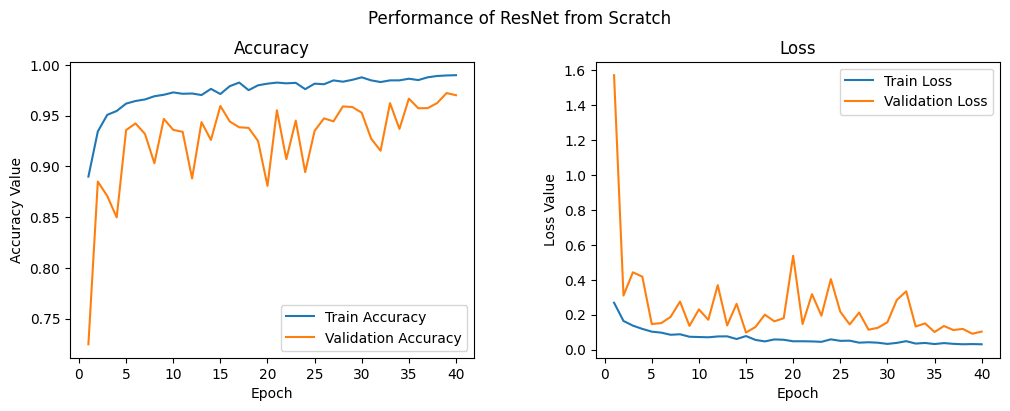

In [25]:
# Plot Accuracy and Loss of Model Trained From Scratch

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance of ResNet from Scratch', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history_from_scratch['train_acc'], label='Train Accuracy')
ax1.plot(epoch_list, history_from_scratch['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history_from_scratch['train_loss'], label='Train Loss')
ax2.plot(epoch_list, history_from_scratch['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

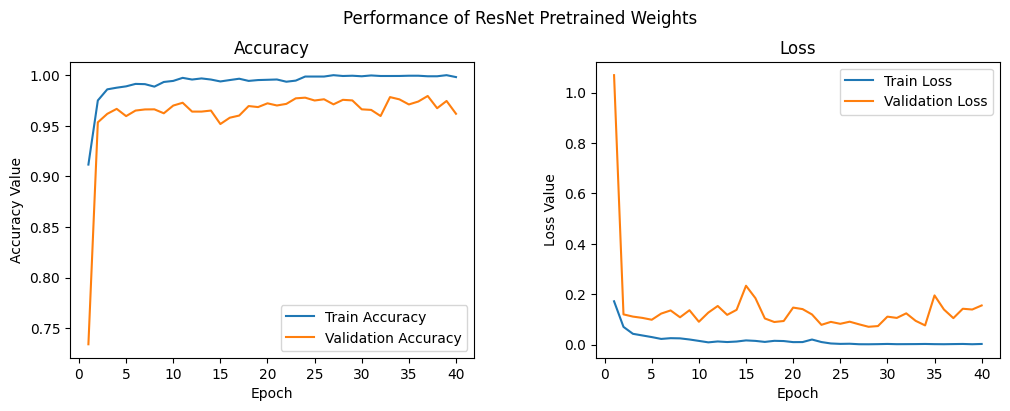

In [26]:
# Plot Accuracy and Loss of Model Trained From Scratch

f, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance of ResNet Pretrained Weights', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax3.plot(epoch_list, history_pretrained['train_acc'], label='Train Accuracy')
ax3.plot(epoch_list, history_pretrained['val_acc'], label='Validation Accuracy')
ax3.set_xticks(np.arange(0, epochs+1, 5))
ax3.set_ylabel('Accuracy Value')
ax3.set_xlabel('Epoch')
ax3.set_title('Accuracy')
l1 = ax3.legend(loc="best")

ax4.plot(epoch_list, history_pretrained['train_loss'], label='Train Loss')
ax4.plot(epoch_list, history_pretrained['val_loss'], label='Validation Loss')
ax4.set_xticks(np.arange(0, epochs+1, 5))
ax4.set_ylabel('Loss Value')
ax4.set_xlabel('Epoch')
ax4.set_title('Loss')
l2 = ax4.legend(loc="best")

# Predict on the Test Set

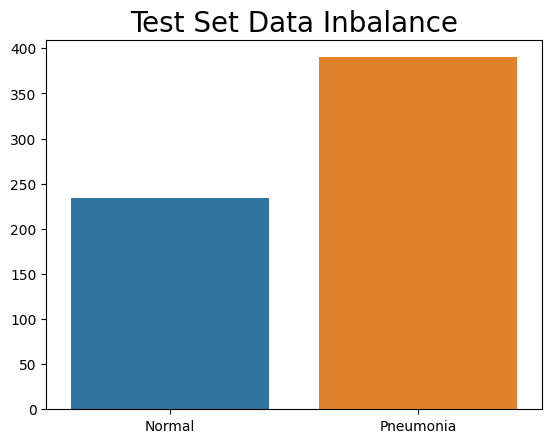

In [27]:
# number of images for each class

test_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/test/NORMAL', filename) 
                     for filename in os.listdir(data_dir+'/test/NORMAL')])], 
     'Pneumonia': [len([os.path.join(data_dir+'/test/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/test/PNEUMONIA')])]})

sns.barplot(data=test_samplesize).set_title('Test Set Data Inbalance', fontsize=20)
plt.show()

In [28]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [model.validation_step(batch) for batch in test_loader] 
    results = model.test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

In [29]:
test_dataset = ImageFolder(data_dir+'/test', 
                           transform=tt.Compose([tt.Resize(255),
                                                 tt.CenterCrop(224),                                                              
                                                 tt.ToTensor()
                                                 #tt.Normalize(mean=[0.485, 0.456, 0.406], 
                                                 #             std=[0.229, 0.224, 0.225],
                                                 #             inplace=True)
                                                ]))

In [30]:
test_dl = DataLoader(test_dataset, batch_size=256)
test_dl = DeviceDataLoader(test_dl, device)


# Evaluate test set using Model Trained From Scratch
print('Predictions using ResNet-18 Trained from Scratch: ')
preds_scratch,labels_scratch = test_predict(model_scratch, test_dl)

# Evaluate test set using Pretrained Model
print('Predictions using ResNet-18 Pretrained: ')
preds_pretrained,labels_pretrained = test_predict(model_pretrained, test_dl)

Predictions using ResNet-18 Trained from Scratch: 
test_loss: 0.7616, test_acc: 0.8590
Predictions using ResNet-18 Pretrained: 
test_loss: 0.6491, test_acc: 0.8932


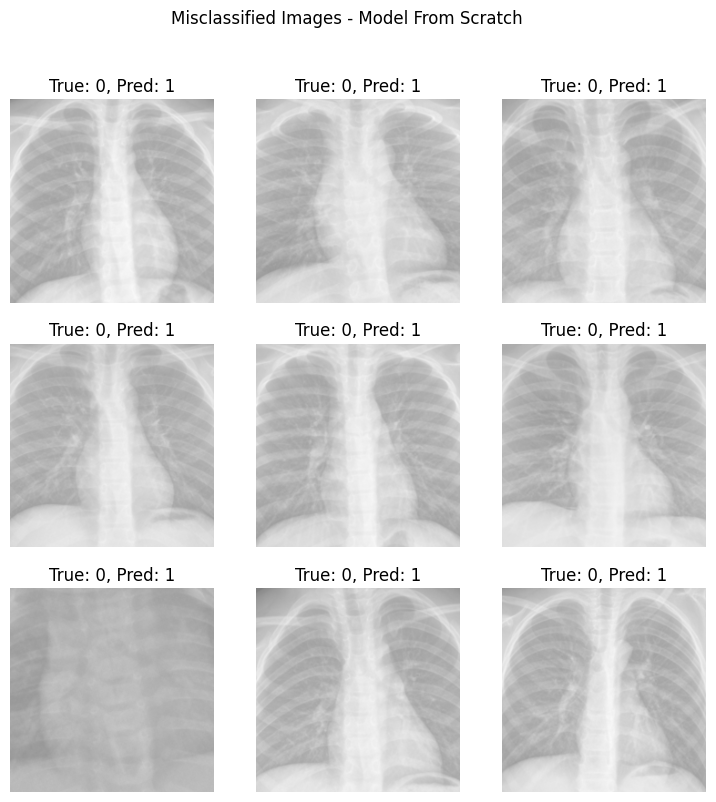

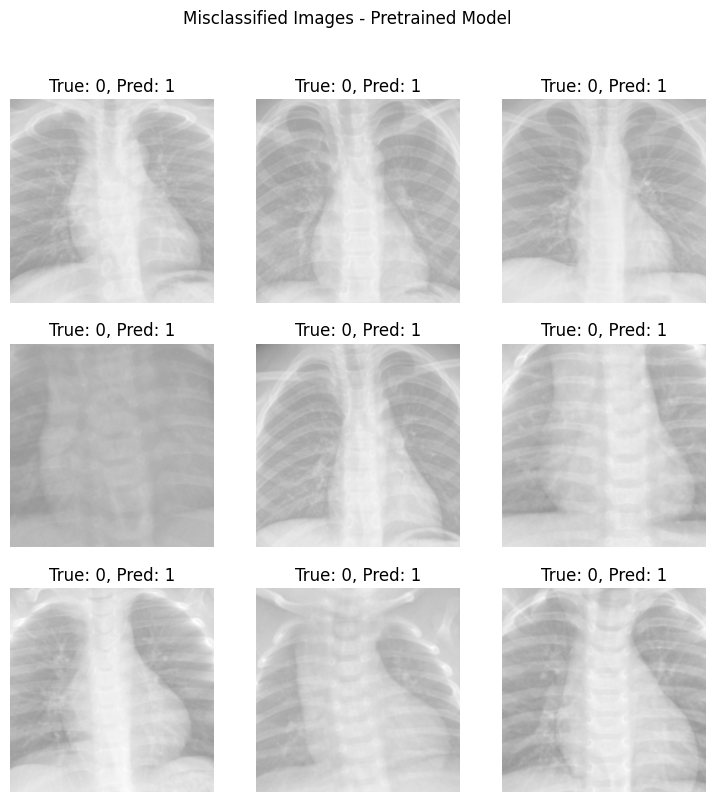

In [ ]:
# Define Miscalssification Function to display missclassified images

def misclassified_plot(model, loader, title):
    model.eval()
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    misclassified = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if preds[i] != labels[i] and misclassified < 9:
                    img = inputs[i].cpu().numpy().transpose((1, 2, 0))
                    img = (img * 0.5) + 0.5  # Unnormalize
                    axes[misclassified // 3, misclassified % 3].imshow(img)
                    axes[misclassified // 3, misclassified % 3].set_title(f"True: {labels[i].item()}, Pred: {preds[i].item()}")
                    axes[misclassified // 3, misclassified % 3].axis("off")
                    misclassified += 1

    plt.suptitle(title)
    plt.show()

misclassified_plot(model_scratch, test_dl, "Misclassified Images - Model From Scratch")
misclassified_plot(model_pretrained, test_dl, "Misclassified Images - Pretrained Model")


In [32]:
# Get VRAM Usage
!nvidia-smi

Mon Feb 10 20:32:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   52C    P0             43W /  125W |    6480MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Plotting Peformance Metrics

<Figure size 640x480 with 0 Axes>

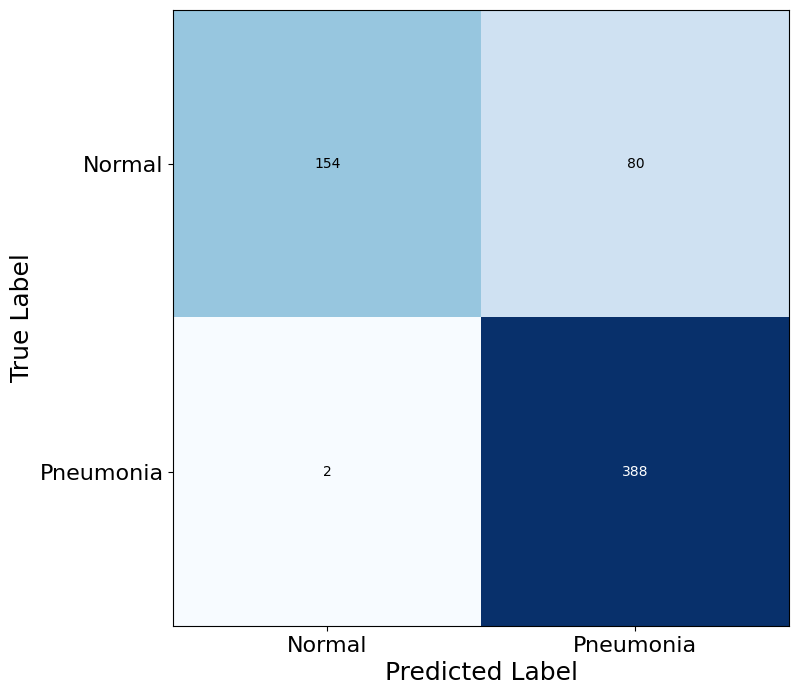

Accuracy of the model is 0.87
Recall of the model is 0.99
Precision of the model is 0.83
F1 Score of the model is 0.90


In [33]:
# Plot confusion matrix ffor pretrained weights

cm_pretrained  = confusion_matrix(labels_pretrained, preds_pretrained)
plt.figure()
plot_confusion_matrix(cm_pretrained,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

# Compute Performance Metrics
tn, fp, fn, tp = cm_pretrained.ravel()

accuracy = (np.array(preds_pretrained) == np.array(labels_pretrained)).sum() / len(preds_pretrained)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

<Figure size 640x480 with 0 Axes>

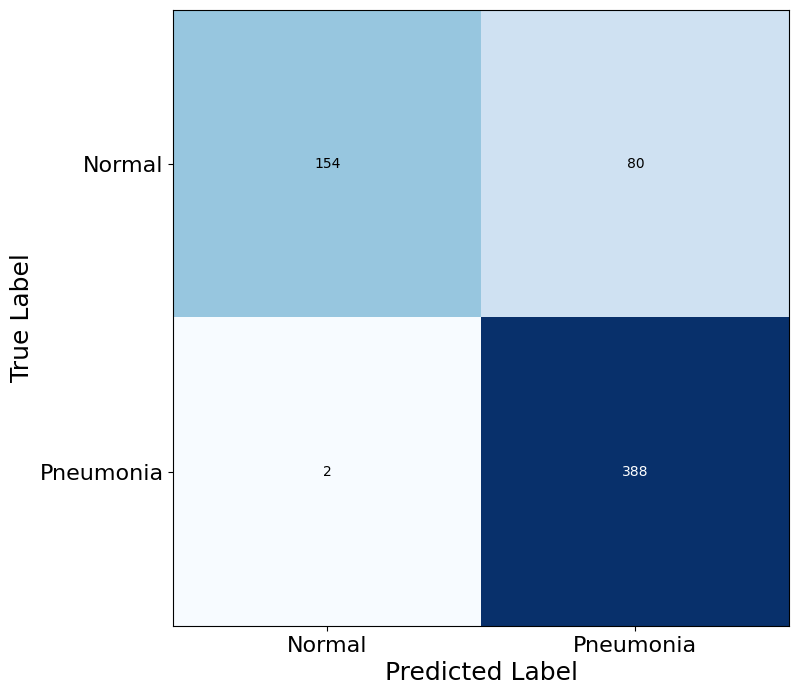

Accuracy of the model is 0.83
Recall of the model is 0.99
Precision of the model is 0.83
F1 Score of the model is 0.90


In [34]:
# Plot confusion matrix ffor pretrained weights

cm_scratch  = confusion_matrix(labels_pretrained, preds_pretrained)
plt.figure()
plot_confusion_matrix(cm_scratch,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

# Compute Performance Metrics
tn, fp, fn, tp = cm_scratch.ravel()

accuracy = (np.array(preds_scratch) == np.array(labels_scratch)).sum() / len(preds_scratch)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))